In [50]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from pathlib import Path
%matplotlib inline

In [51]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Regression Analysis: Seasonal Effects with Sklearn Linear Regression
In this notebook, you will build a SKLearn linear regression model to predict Yen futures ("settle") returns with *lagged* Yen futures returns. 

In [52]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_dollar = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_dollar.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [53]:
# Trim the dataset to begin on January 1st, 1990
yen_dollar = yen_dollar.loc["1990-01-01":, :]
yen_dollar.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


# Data Preparation

### Returns

In [54]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
yen_dollar['returns'] = yen_dollar[["Settle"]].pct_change() * 100
yen_dollar = yen_dollar.replace(-np.inf, np.nan).dropna()
yen_dollar.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,returns
Date,,,,,,,,,
2014-02-18,9831.0,9865.0,9734.0,9775.0,42.0,9775.0,203495.0,196924.0,-0.427829
2014-02-19,9768.0,9825.0,9760.0,9773.0,2.0,9773.0,129508.0,197197.0,-0.020460
2014-02-20,9774.0,9837.0,9765.0,9775.0,2.0,9775.0,160202.0,198280.0,0.020465
2014-02-21,9772.0,9776.0,9725.0,9758.0,20.0,9755.0,103091.0,202990.0,-0.204604
2014-02-24,9752.0,9789.0,9740.0,9757.0,2.0,9757.0,90654.0,203114.0,0.020502


### Lagged Returns 

In [55]:
# Create a lagged return using the shift function
yen_dollar['lagged_returns'] = yen_dollar['returns'].shift() 
yen_dollar = yen_dollar.dropna()
yen_dollar.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,returns,lagged_returns
Date,,,,,,,,,,
2014-02-19,9768.0,9825.0,9760.0,9773.0,2.0,9773.0,129508.0,197197.0,-0.020460,-0.427829
2014-02-20,9774.0,9837.0,9765.0,9775.0,2.0,9775.0,160202.0,198280.0,0.020465,-0.020460
2014-02-21,9772.0,9776.0,9725.0,9758.0,20.0,9755.0,103091.0,202990.0,-0.204604,0.020465
2014-02-24,9752.0,9789.0,9740.0,9757.0,2.0,9757.0,90654.0,203114.0,0.020502,-0.204604
2014-02-25,9760.0,9808.0,9744.0,9789.0,32.0,9789.0,105498.0,201486.0,0.327970,0.020502


### Train Test Split

In [56]:
# Create a train/test split for the data using 2018-2019 for testing and the rest for training
train = yen_dollar['2018' : '2019']
test = yen_dollar['2018' : '2019']

In [57]:
# Create four dataframes:
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
# Y_train (training set using just the "y" variable, i.e., "Futures Return"), Y_test (test set of just the "y" variable):
X_train = train["lagged_returns"].to_frame()
y_train = train["returns"]

X_test = test["lagged_returns"].to_frame()
y_test = test["returns"]

In [59]:
#Testing the X_train variables 
X_train

,lagged_returns
Date,
2018-01-02,0.224871
2018-01-03,0.297285
2018-01-04,-0.240479
2018-01-05,-0.213028
2018-01-08,-0.353933
...,...
2019-10-09,0.170931
2019-10-10,-0.410601
2019-10-11,-0.369458


In [60]:
#Testing the y_train variables 
y_train

Date
2018-01-02    0.297285
2018-01-03   -0.240479
2018-01-04   -0.213028
2018-01-05   -0.353933
2018-01-08    0.062017
                ...   
2019-10-09   -0.410601
2019-10-10   -0.369458
2019-10-11   -0.564304
2019-10-14    0.151335
2019-10-15   -0.469509
Name: returns, Length: 448, dtype: float64

# Linear Regression Model

In [61]:
# Create a Linear Regression model and fit it to the training data
# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
model_lg = LinearRegression()
model_lg.fit(X_train, y_train)

LinearRegression()

# Make predictions using the Testing Data

Note: We want to evaluate the model using data that it has never seen before, in this case: X_test.

In [72]:
# Make a prediction of "y" values using just the test dataset
predicted_y_values = model_lg.predict(X_test)

In [73]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Res = y_test.to_frame()
Res['Predicted Return'] = predicted_y_values

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000029E894FC280>,
      dtype=object)

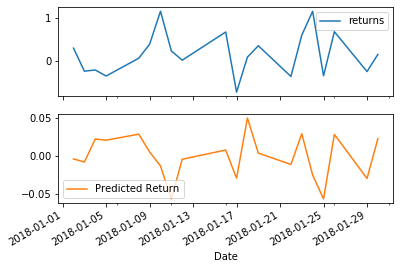

In [74]:
# Plot the first 20 predictions vs the true values
Res[:20].plot(subplots=True)

In [75]:
Res

,returns,Predicted Return
Date,,
2018-01-02,0.297285,-0.003756
2018-01-03,-0.240479,-0.007863
2018-01-04,-0.213028,0.022637
2018-01-05,-0.353933,0.021080
2018-01-08,0.062017,0.029072
...,...,...
2019-10-09,-0.410601,-0.000696
2019-10-10,-0.369458,0.032286
2019-10-11,-0.564304,0.029952


# Out-of-Sample Performance

Evaluate the model using "out-of-sample" data (X_test and y_test)

In [76]:
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
mse = mean_squared_error(Res['returns'], Res['Predicted Return'])

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
out_of = np.sqrt(mse)
print(f"Out of the sample RMSE: {out_of}")


Out of the sample RMSE: 0.4145807716682036


# In-Sample Performance

Evaluate the model using in-sample data (X_train and y_train)

In [77]:
# Construct a dataframe using just the "y" training data:
in_sam = y_train.to_frame()
in_sam

,returns
Date,
2018-01-02,0.297285
2018-01-03,-0.240479
2018-01-04,-0.213028
2018-01-05,-0.353933
2018-01-08,0.062017
...,...
2019-10-09,-0.410601
2019-10-10,-0.369458
2019-10-11,-0.564304


In [78]:
# Add a column of "in-sample" predictions to that dataframe:  
in_sam['In-Sample Prediction'] = model_lg.predict(X_train)

# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
in_sam_mse = mean_squared_error(in_sam['returns'], in_sam['In-Sample Prediction'])

# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
in_sam_rmse = np.sqrt(in_sam_mse)

print(f"Out of the sample RMSE: {in_sam_rmse}")

Out of the sample RMSE: 0.4145807716682036


# Conclusions

YOUR CONCLUSIONS HERE!

Does this model perform better or worse on out-of-sample data compared to in-sample data?
The results from my analysis are the exact same. Hence based on these results my conclussion is that they are both equaly good models to use to obtain the results needed. 
